# Table of Contents
 <p><div class="lev1"><a href="#Measure-Dynamic-Functional-Connectivity"><span class="toc-item-num">1&nbsp;&nbsp;</span>Measure Dynamic Functional Connectivity</a></div><div class="lev2"><a href="#Initialize-Environment"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Initialize Environment</a></div><div class="lev2"><a href="#Gather-all-data-sets"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Gather all data sets</a></div><div class="lev2"><a href="#Generate-processing-list"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Generate processing list</a></div><div class="lev2"><a href="#Submit-proc_list-to-qsub-as-jobs"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Submit proc_list to qsub as jobs</a></div><div class="lev2"><a href="#Continuously-monitor-queue-size-and-run-remaining-jobs"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Continuously monitor queue size and run remaining jobs</a></div><div class="lev1"><a href="#Check-Adjacency"><span class="toc-item-num">2&nbsp;&nbsp;</span>Check Adjacency</a></div>

# Measure Dynamic Functional Connectivity

## Initialize Environment

In [10]:
try:
    %load_ext autoreload
    %autoreload 2
    %reset
except:
    print 'NOT IPYTHON'

from __future__ import division

import os
import sys
import glob
import time

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import scipy.io as io
import h5py
import matplotlib.pyplot as plt
from matplotlib import rcParams

sys.path.append('/home/akhambhati/JagHome/hoth_research/Echobase')
import Echobase

rcParams = Echobase.Plotting.fig_format.update_rcparams(rcParams)

path_CoreData = '/data/jag/akhambhati/Remotes/CORE.RAM_Stim'
path_PeriphData = '/home/akhambhati/Procd_Data/RSRCH.RAM_Stim'
path_ExpData = path_PeriphData + '/e01-FuncNetw-Baseline'

for path in [path_CoreData, path_PeriphData, path_ExpData]:
    if not os.path.exists(path):
        print('Path: {}, does not exist'.format(path))
        os.makedirs(path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Gather all data sets

In [11]:
path_list = glob.glob('{}/Baseline_DataFiles/*.mat'.format(path_CoreData))

subj_dict = {}
for pth in path_list:    
    full_file = pth.split('/')[-1]    
    subj_id = full_file.split('.')[0]

    chan_file = glob.glob('{}/Channel_Info/{}.mat'.format(path_CoreData, subj_id))
    if len(chan_file) != 1:
        continue
    chan_file = chan_file[0]
    
    meta_file = glob.glob('{}/Subjects/{}.*.mat'.format(path_CoreData, subj_id))
    if len(meta_file) == 0:
        continue
    meta_file = meta_file[0]
    
    trial_id = full_file.split('.')[1]
    
    if not subj_id in subj_dict.keys():
        subj_dict[subj_id] = {}        
    if not trial_id in subj_dict[subj_id].keys():
        subj_dict[subj_id][trial_id] = {'chan_path': chan_file,
                                        'meta_path': meta_file,
                                        'raw_path': pth,
                                        'raw_name': '{}.{}'.format(subj_id,
                                                                   trial_id)}    

## Generate processing list

In [24]:
def gen_proc_list():
    proc_item = []
    fin_items = []
    for subj_id in subj_dict.keys():
        for trial_id in subj_dict[subj_id].keys():
            
            chan_path = subj_dict[subj_id][trial_id]['chan_path']
            meta_path = subj_dict[subj_id][trial_id]['meta_path']            
            raw_path = subj_dict[subj_id][trial_id]['raw_path']
            raw_name = subj_dict[subj_id][trial_id]['raw_name']
            res_path = '{}/Adjacency.{}.npz'.format(path_ExpData, raw_name)

            if os.path.exists(res_path):
                fin_items.append(res_path)
                continue

            if os.path.exists('{}/Adjacency.{}.stdout'.format(path_ExpData, raw_name)):
                continue

            proc_item.append({'chan_path': chan_path,
                              'meta_path': meta_path,
                              'raw_path': raw_path,
                              'raw_name': raw_name,
                              'res_path': res_path})
    print('There are {} jobs to process.'.format(len(proc_item)))
    print('There are {} jobs complete.'.format(len(fin_items)))
    
    return proc_item, fin_items

## Submit proc_list to qsub as jobs

In [25]:
def submit_job_file(proc_items):
    # Submit proc_item list as jobs to qsub
    job_file = open('./e01-Measure_Adjacency.job', 'w')
    job_file.write('#!/bin/bash\n\n')
    for pitem in proc_items:    
        stdout_path = '{}/Adjacency.{}.stdout'.format(path_ExpData, pitem['raw_name'])
        stderr_path = '{}/Adjacency.{}.stderr'.format(path_ExpData, pitem['raw_name'])

        py_str = './e01-Measure_Adjacency_Baseline {} {} {} {}'.format(
            pitem['raw_path'], pitem['chan_path'], pitem['meta_path'], pitem['res_path'])

        cmd_str = 'qsub -cwd -o {} -e {} -l h_vmem=6.1G,s_vmem=6G -q all.q,basic.q'.format(stdout_path, stderr_path)

        job_file.write('{} {}\n'.format(cmd_str, py_str))
    job_file.close()

    !sh e01-Measure_Adjacency.job > job_dump
    !rm -r job_dump

## Continuously monitor queue size and run remaining jobs

In [26]:
proc_item, fin_items = gen_proc_list()

while True:
    # Check status of queue
    n_queue_size = !qstat | wc -l
    n_queue_size = int(n_queue_size[0])
    
    if n_queue_size == 0:
        proc_item, fin_items = gen_proc_list()
        submit_job_file(np.random.permutation(proc_item))

    if len(proc_item) == 0:
        break

    time.sleep(60)

There are 570 jobs to process.
There are 0 jobs complete.
There are 570 jobs to process.
There are 0 jobs complete.
There are 1 jobs to process.
There are 530 jobs complete.
There are 0 jobs to process.
There are 530 jobs complete.


# Check Adjacency

No-Stimulus Adjacency


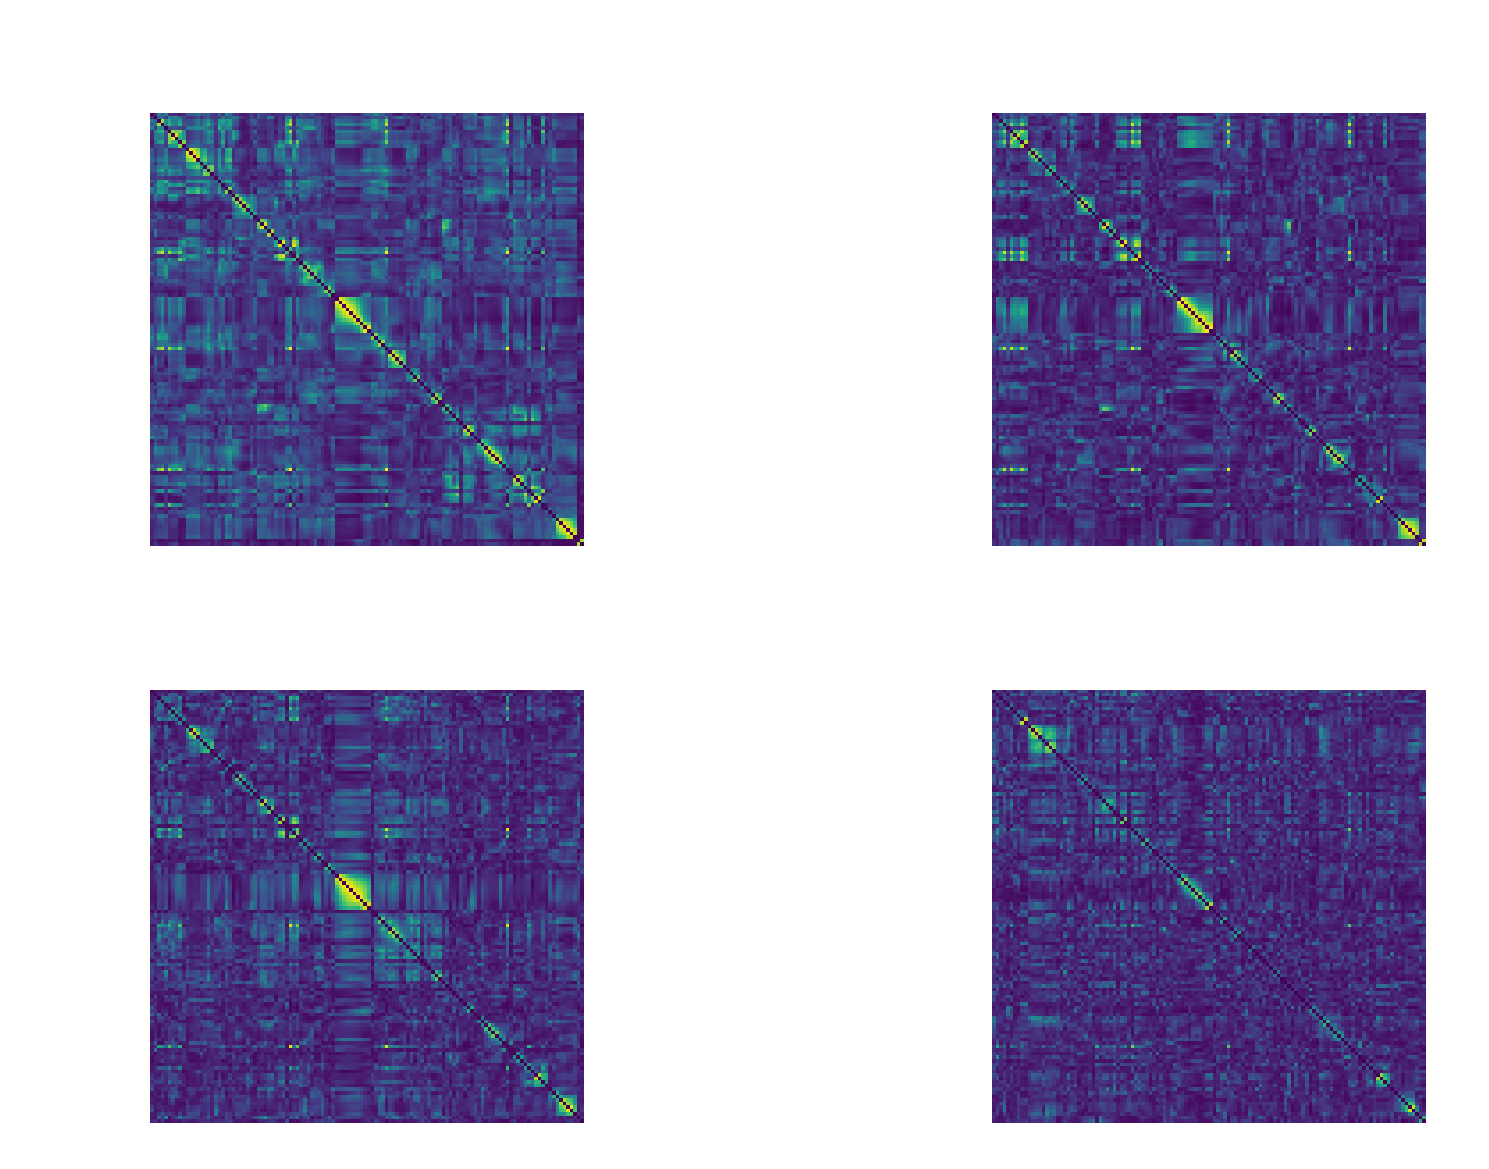

In [28]:
%matplotlib inline

# Check fin_items for a list of processed adjacency matrices
adj = np.load('/home/akhambhati/Procd_Data/RSRCH.RAM_Stim/e01-FuncNetw-Baseline/Adjacency.R1061T.baseline_5.npz')['adj'].item()

print('No-Stimulus Adjacency')
plt.figure()
ax = plt.subplot(2,2,1); ax.matshow(adj['No_Stim']['AlphaTheta'], cmap='viridis', vmin=0, vmax=1); ax.set_axis_off();
ax = plt.subplot(2,2,2); ax.matshow(adj['No_Stim']['Beta'], cmap='viridis', vmin=0, vmax=1); ax.set_axis_off();
ax = plt.subplot(2,2,3); ax.matshow(adj['No_Stim']['LowGamma'], cmap='viridis', vmin=0, vmax=1); ax.set_axis_off();
ax = plt.subplot(2,2,4); ax.matshow(adj['No_Stim']['HighGamma'], cmap='viridis', vmin=0, vmax=1); ax.set_axis_off();
plt.show()